In [1]:
import os, glob
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

DATA_DIR = "patterns"
SEQ_LEN = 64

FEATURE_COLS = ["open", "high", "low", "close", "r"]

CLASSES = ["Bearish", "Bullish"]
class_to_id = {"Bearish": 0, "Bullish": 1}
num_classes = 2


MAX_SEQS_PER_FILE = None
MIN_GROUP_LEN = 1

all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
print("Found files:", len(all_files))
print(*all_files[:20], sep="\n")

Found files: 17
patterns\1day_sigma0.01.csv
patterns\1day_sigma0.02.csv
patterns\1day_sigma0.05.csv
patterns\1day_sigma0.07.csv
patterns\1day_sigma0.1.csv
patterns\1hour_sigma0.005.csv
patterns\1hour_sigma0.01.csv
patterns\1hour_sigma0.02.csv
patterns\1hour_sigma0.05.csv
patterns\1minute_sigma0.001.csv
patterns\1minute_sigma0.002.csv
patterns\1minute_sigma0.005.csv
patterns\1minute_sigma0.01.csv
patterns\4hours_sigma0.005.csv
patterns\4hours_sigma0.01.csv
patterns\4hours_sigma0.02.csv
patterns\4hours_sigma0.05.csv


In [3]:
JUNK_COLS = {"Unnamed: 0", "Unnamed:0", "index", "level_0"}

REQUIRED_COLS = {"date", "open", "high", "low", "close", "r", "pattern"}

def load_and_clean_csv(path):
    # Read only needed columns if present
    cols = pd.read_csv(path, nrows=0).columns.tolist()
    cols = [c for c in cols if c not in JUNK_COLS]

    # Ensure we include required cols if they exist
    usecols = [c for c in cols if c in REQUIRED_COLS]

    df = pd.read_csv(path, usecols=usecols)

    # Drop junk cols again just in case
    df = df.drop(columns=[c for c in df.columns if c in JUNK_COLS], errors="ignore")

    # Basic column existence check
    missing = REQUIRED_COLS - set(df.columns)
    if missing:
        raise ValueError(f"{os.path.basename(path)} missing columns: {missing}")

    # Parse date + sort
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"])
    df = df.sort_values("date")

    # Ensure pattern is string
    df["pattern"] = df["pattern"].fillna("no-pattern").astype(str)

    # Convert features to numeric
    for c in FEATURE_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Handle NaNs:
    df["r"] = df["r"].fillna(0.0)  # r NaNs are common -> fill with 0

    # If OHLC are NaN, drop those rows
    df = df.dropna(subset=["open", "high", "low", "close"])

    # For Bull/Bear experiment:
    # Keep only Bull* / Bear* patterns + no-pattern (filter out typos)
    allowed_prefix = ("Bull", "Bear", "no-pattern")
    df = df[df["pattern"].str.startswith(allowed_prefix)].copy()

    return df

In [4]:
def df_to_sequences(df):
    # Drop no-pattern for training
    df = df[df["pattern"] != "no-pattern"].copy()
    if len(df) == 0:
        return None, None

    # Group consecutive identical patterns
    df["group_id"] = (df["pattern"] != df["pattern"].shift(1)).cumsum()

    X_list, y_list = [], []

    for _, g in df.groupby("group_id"):
        raw_label = g["pattern"].iloc[0]

        # Map 12 classes -> 2 classes
        if raw_label.startswith("Bull"):
            label = "Bullish"
        elif raw_label.startswith("Bear"):
            label = "Bearish"
        else:
            continue  # safety

        # NOTE: make sure you set:
        # CLASSES = ["Bearish","Bullish"]
        # class_to_id = {"Bearish":0,"Bullish":1}
        if label not in class_to_id:
            continue

        feat = g[FEATURE_COLS].values.astype(np.float32)

        if len(feat) < MIN_GROUP_LEN:
            continue

        # fixed-length window via pad/truncate
        if len(feat) >= SEQ_LEN:
            seq = feat[-SEQ_LEN:]
        else:
            pad_len = SEQ_LEN - len(feat)
            pad = np.zeros((pad_len, feat.shape[1]), dtype=np.float32)
            seq = np.concatenate([pad, feat], axis=0)

        X_list.append(seq)
        y_list.append(class_to_id[label])

        if MAX_SEQS_PER_FILE is not None and len(X_list) >= MAX_SEQS_PER_FILE:
            break

    if len(X_list) == 0:
        return None, None

    X = np.stack(X_list)  # (n_seq, SEQ_LEN, n_feat)
    y = np.array(y_list, dtype=np.int64)
    return X, y

In [5]:
all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))

EVAL_FILES = [
    os.path.join(DATA_DIR, "1hour_sigma0.01.csv"),
    os.path.join(DATA_DIR, "1minute_sigma0.005.csv"),
    os.path.join(DATA_DIR, "1day_sigma0.02.csv"),
]

# Train files = everything except eval files
train_files = [f for f in all_files if f not in EVAL_FILES]

print("Train files:", len(train_files))
print("Eval files:", len(EVAL_FILES))
print(
    "Overlap(train, eval) =",
    set(map(os.path.basename, train_files)).intersection(
        set(map(os.path.basename, EVAL_FILES))
    )
)


Train files: 14
Eval files: 3
Overlap(train, eval) = set()


In [6]:
total = Counter()
per_file_counts = {}

for path in all_files:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        print("No patterns found in:", os.path.basename(path))
        continue
    counts = Counter(y)
    per_file_counts[os.path.basename(path)] = len(y)
    total.update(counts)

print("Total sequences across files:", sum(per_file_counts.values()))
print("Per-file sequences (first 10):", list(per_file_counts.items())[:10])

# Convert total counts to label names
inv = {v:k for k,v in class_to_id.items()}
print("Total label distribution:")
for k,v in total.most_common():
    print(inv[k], v)

Total sequences across files: 347783
Per-file sequences (first 10): [('1day_sigma0.01.csv', 3225), ('1day_sigma0.02.csv', 1453), ('1day_sigma0.05.csv', 370), ('1day_sigma0.07.csv', 229), ('1day_sigma0.1.csv', 117), ('1hour_sigma0.005.csv', 5523), ('1hour_sigma0.01.csv', 3225), ('1hour_sigma0.02.csv', 1453), ('1hour_sigma0.05.csv', 370), ('1minute_sigma0.001.csv', 178282)]
Total label distribution:
Bullish 174638
Bearish 173145


In [7]:
#We use one global scaler for everything
scaler = StandardScaler()

for path in train_files:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        continue

    Xp = X.reshape(-1, X.shape[-1])
    nonpad = ~(np.all(Xp == 0, axis=1))   # ignore padded rows
    scaler.partial_fit(Xp[nonpad])

def scale_X(X):
    s, t, f = X.shape
    X2 = X.reshape(-1, f)
    X2 = scaler.transform(X2)
    return X2.reshape(s, t, f).astype(np.float32)

In [ ]:
def dilated_conv_block(x, filters, kernel_size, dilation, dropout=0.0, name=None):
    x = layers.Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        dilation_rate=dilation,
        padding="same",
        use_bias=False,
        name=None if name is None else f"{name}_conv_k{kernel_size}_d{dilation}"
    )(x)
    x = layers.BatchNormalization(name=None if name is None else f"{name}_bn_k{kernel_size}_d{dilation}")(x)
    x = layers.ReLU(name=None if name is None else f"{name}_relu_k{kernel_size}_d{dilation}")(x)
    if dropout and dropout > 0:
        x = layers.Dropout(dropout, name=None if name is None else f"{name}_drop_k{kernel_size}_d{dilation}")(x)
    return x

def module_7(x, filters=64, dropout=0.0, name="m7"):
    x = dilated_conv_block(x, filters, 3, 1, dropout, name)
    x = dilated_conv_block(x, filters, 3, 2, dropout, name)
    return x

def module_10(x, filters=64, dropout=0.0, name="m10"):
    x = dilated_conv_block(x, filters, 3, 1, dropout, name)
    x = dilated_conv_block(x, filters, 3, 2, dropout, name)
    x = dilated_conv_block(x, filters, 2, 4, dropout, name)
    return x

def module_15(x, filters=64, dropout=0.0, name="m15"):
    x = dilated_conv_block(x, filters, 3, 1, dropout, name)
    x = dilated_conv_block(x, filters, 3, 2, dropout, name)
    x = dilated_conv_block(x, filters, 3, 4, dropout, name)
    return x

In [ ]:
def build_liu_si_cnn_lstm(seq_len, num_features, num_classes,
                          filters=64, module_dropout=0.1, head_dropout=0.3,
                          lstm_units=64, bidirectional=True):
    inp = layers.Input(shape=(seq_len, num_features), name="input")

    x_in = inp

    b7  = module_7(x_in,  filters=filters, dropout=module_dropout, name="module7")
    b10 = module_10(x_in, filters=filters, dropout=module_dropout, name="module10")
    b15 = module_15(x_in, filters=filters, dropout=module_dropout, name="module15")

    x = layers.Concatenate(name="concat")([b7, b10, b15])

    x = layers.MaxPooling1D(pool_size=2, name="maxpool")(x)

    # 1x1 conv to mix channels after concatenation
    x = layers.Conv1D(filters=filters, kernel_size=1, padding="same", use_bias=False, name="conv1x1")(x)
    x = layers.BatchNormalization(name="conv1x1_bn")(x)
    x = layers.ReLU(name="conv1x1_relu")(x)

    x = layers.Dropout(head_dropout, name="head_dropout")(x)

    # LSTM goes here (while time dimension still exists)
    if bidirectional:
        x = layers.Bidirectional(layers.LSTM(lstm_units), name="bilstm")(x)
    else:
        x = layers.LSTM(lstm_units, name="lstm")(x)

    # Classifier head
    x = layers.Dropout(0.3, name="post_lstm_dropout")(x)
    x = layers.Dense(64, activation="relu", name="fc")(x)
    x = layers.Dropout(0.3, name="fc_dropout")(x)

    out = layers.Dense(num_classes, activation="softmax", name="softmax")(x)

    return Model(inp, out, name="LiuSi_CNN_BiLSTM")

In [9]:
seq_len = SEQ_LEN
num_features = len(FEATURE_COLS)
num_classes = len(CLASSES)

cnn_lstm = build_liu_si_cnn_lstm(
    seq_len=SEQ_LEN,
    num_features=len(FEATURE_COLS),
    num_classes=len(CLASSES),
    filters=64,
    module_dropout=0.1,
    head_dropout=0.3,
    lstm_units=64,
    bidirectional=True
)

cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_lstm.summary()


Model: "LiuSi_CNN_BiLSTM"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 64, 5)]              0         []                            
                                                                                                  
 module10_conv_k3_d1 (Conv1  (None, 64, 64)               960       ['input[0][0]']               
 D)                                                                                               
                                                                                                  
 module15_conv_k3_d1 (Conv1  (None, 64, 64)               960       ['input[0][0]']               
 D)                                                                                               
                                                                                   

In [10]:
# Define evaluation files FIRST (so we can exclude them from training)
EVAL_FILES = [
    "1hour_sigma0.01.csv",
    "1minute_sigma0.005.csv",
    "1day_sigma0.02.csv"
]
EVAL_FILES = [os.path.join(DATA_DIR, f) for f in EVAL_FILES]
eval_set = set(EVAL_FILES)

# Build a small fixed validation set (from NON-eval files) This is used for early stopping across global passes.
X_val_list, y_val_list = [], []
VAL_TARGET_SEQS = 4000  # you can lower this if memory/time is an issue

for path in train_files:
    if path in eval_set:
        continue
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        continue
    X = scale_X(X)
    X_val_list.append(X)
    y_val_list.append(y)
    if sum(len(a) for a in y_val_list) >= VAL_TARGET_SEQS:
        break

X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)

# Optional shuffle and cap exactly
idx = np.random.permutation(len(X_val))
X_val, y_val = X_val[idx], y_val[idx]
if len(X_val) > VAL_TARGET_SEQS:
    X_val, y_val = X_val[:VAL_TARGET_SEQS], y_val[:VAL_TARGET_SEQS]

print("Validation set shape:", X_val.shape, y_val.shape)

Validation set shape: (4000, 64, 5) (4000,)


In [11]:
# Compute class weights from training distribution (excluding eval files)
y_for_weights = []

for path in train_files:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        continue
    y_for_weights.append(y)

y_for_weights = np.concatenate(y_for_weights, axis=0)

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=y_for_weights
)
class_weight_dict = {i: float(w) for i, w in enumerate(weights)}
print("Class weights:", class_weight_dict)


Class weights: {0: 1.0051226175762702, 1: 0.9949293326035865}


In [12]:
PATIENCE = 3
best_val_loss = np.inf
patience_counter = 0
best_weights = None

EPOCHS_PER_FILE = 1
BATCH_SIZE = 64
GLOBAL_PASSES = 20

for gp in range(GLOBAL_PASSES):
    train_files_shuffled = train_files.copy()
    np.random.shuffle(train_files_shuffled)
    print(f"\n=== Global pass {gp+1}/{GLOBAL_PASSES} ===")

    for path in train_files_shuffled:
        df = load_and_clean_csv(path)
        X, y = df_to_sequences(df)
        if X is None:
            continue

        X = scale_X(X)

        idx = np.random.permutation(len(X))
        X, y = X[idx], y[idx]

        cnn_lstm.fit(
            X, y,
            epochs=EPOCHS_PER_FILE,
            batch_size=BATCH_SIZE,
            verbose=0,
            class_weight=class_weight_dict
        )

    val_loss, val_acc = cnn_lstm.evaluate(X_val, y_val, verbose=0)
    print(f"Validation -> loss: {val_loss:.4f} | acc: {val_acc:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        patience_counter = 0
        best_weights = cnn_lstm.get_weights()
        print("Improved val_loss. Saved best weights.")
    else:
        patience_counter += 1
        print(f"No improvement. patience {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# Restore best weights at end
if best_weights is not None:
    cnn_lstm.set_weights(best_weights)
    print("Restored best model weights from validation.")



=== Global pass 1/20 ===
Validation -> loss: 0.2908 | acc: 0.8802
Improved val_loss. Saved best weights.

=== Global pass 2/20 ===
Validation -> loss: 0.5245 | acc: 0.7682
No improvement. patience 1/3

=== Global pass 3/20 ===
Validation -> loss: 0.2933 | acc: 0.8740
No improvement. patience 2/3

=== Global pass 4/20 ===
Validation -> loss: 0.2383 | acc: 0.9032
Improved val_loss. Saved best weights.

=== Global pass 5/20 ===
Validation -> loss: 0.2949 | acc: 0.8717
No improvement. patience 1/3

=== Global pass 6/20 ===
Validation -> loss: 0.3699 | acc: 0.8275
No improvement. patience 2/3

=== Global pass 7/20 ===
Validation -> loss: 0.2465 | acc: 0.8980
No improvement. patience 3/3
Early stopping triggered.
Restored best model weights from validation.


In [19]:
# Build the Evaluation dataset
X_eval_list = []
y_eval_list = []

for path in EVAL_FILES:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        continue
    X = scale_X(X)
    X_eval_list.append(X)
    y_eval_list.append(y)

X_eval = np.concatenate(X_eval_list, axis=0)
y_eval = np.concatenate(y_eval_list, axis=0)

print("Evaluation set shape:", X_eval.shape, y_eval.shape)


Evaluation set shape: (38748, 64, 5) (38748,)


In [20]:
# Run cnn_lstm predictions + report
y_probs = cnn_lstm.predict(X_eval, verbose=0)
y_pred = np.argmax(y_probs, axis=1)

print(
    classification_report(
        y_eval,
        y_pred,
        labels=np.arange(num_classes),
        target_names=CLASSES,
        zero_division=0
    )
)

              precision    recall  f1-score   support

     Bearish       0.81      0.88      0.84     19415
     Bullish       0.86      0.79      0.82     19333

    accuracy                           0.83     38748
   macro avg       0.84      0.83      0.83     38748
weighted avg       0.84      0.83      0.83     38748



In [21]:
print("Eval files:", [os.path.basename(p) for p in EVAL_FILES])

# Ensure eval files are NOT in training list:
train_set = set(map(os.path.basename, train_files))
eval_set  = set(map(os.path.basename, EVAL_FILES))
print("Overlap(train, eval) =", train_set.intersection(eval_set))


Eval files: ['1hour_sigma0.01.csv', '1minute_sigma0.005.csv', '1day_sigma0.02.csv']
Overlap(train, eval) = set()


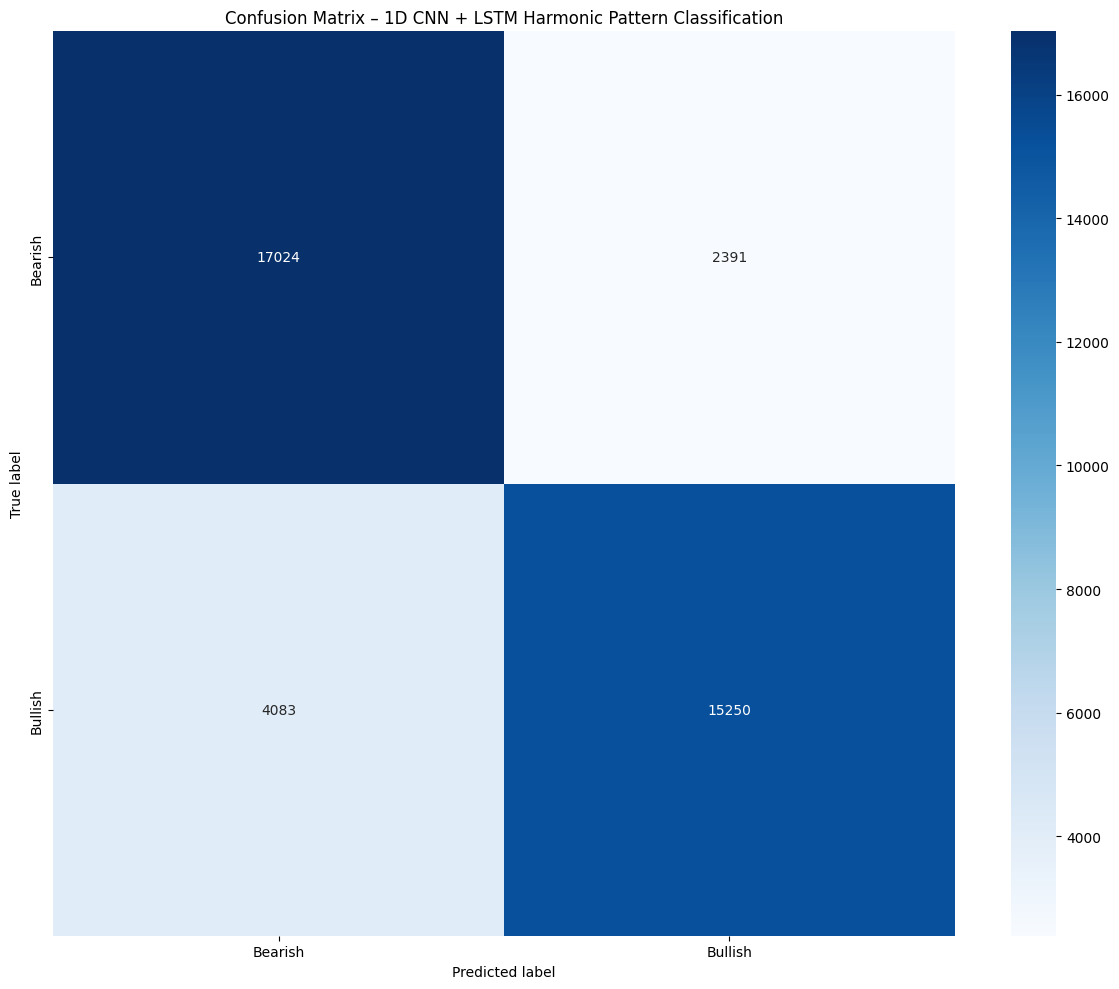

In [22]:
cm = confusion_matrix(
    y_eval,
    y_pred,
    labels=np.arange(num_classes)
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASSES,
    yticklabels=CLASSES
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – 1D CNN + LSTM Harmonic Pattern Classification")
plt.tight_layout()
plt.show()

In [23]:
cnn_lstm.save("cnn_lstm_bull_bear_model.keras")

In [24]:
cnn_lstm = tf.keras.models.load_model("cnn_lstm_bull_bear_model.keras")

Found 39971 candidate groups across eval files


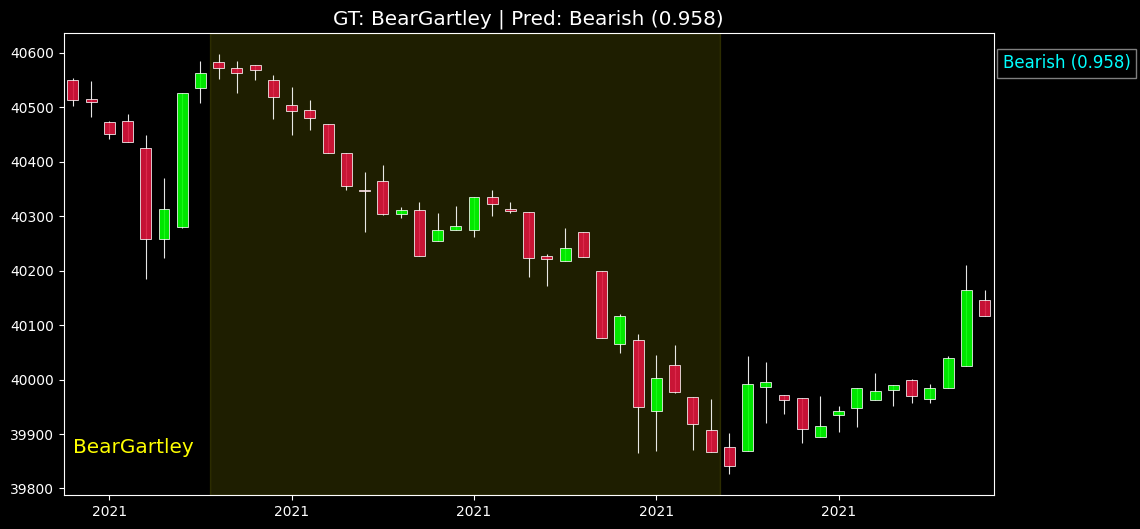

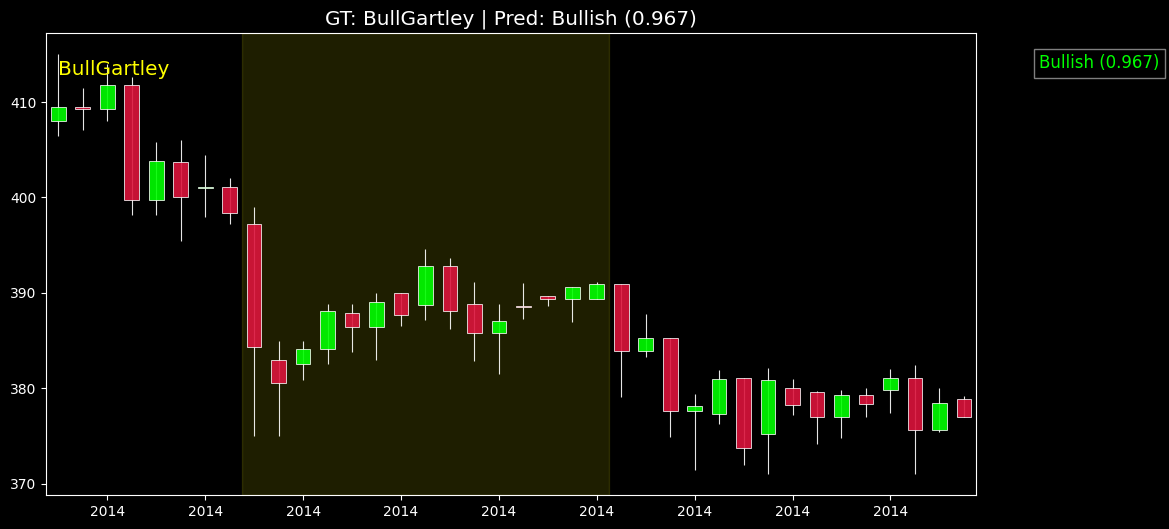

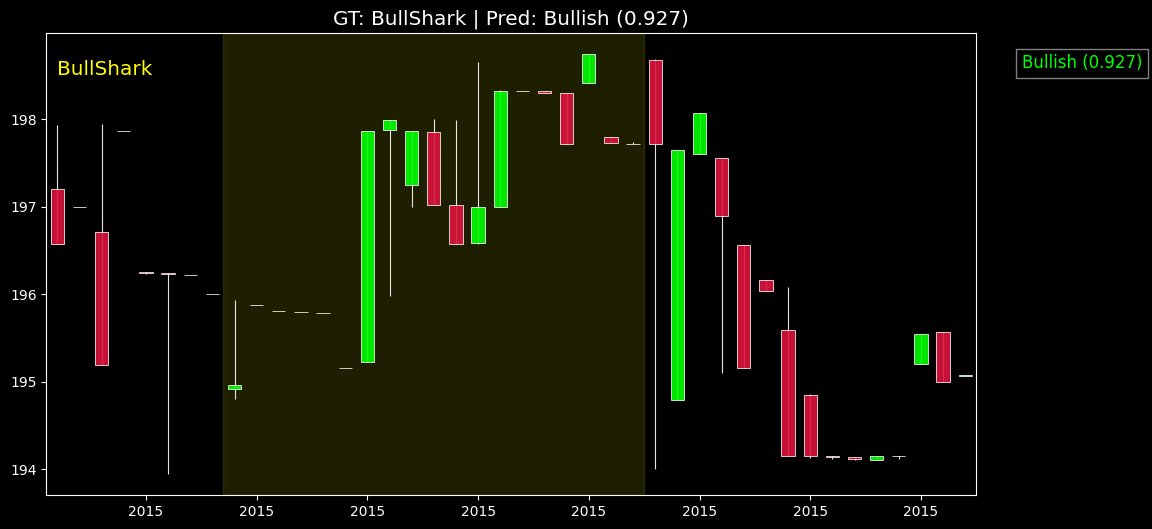

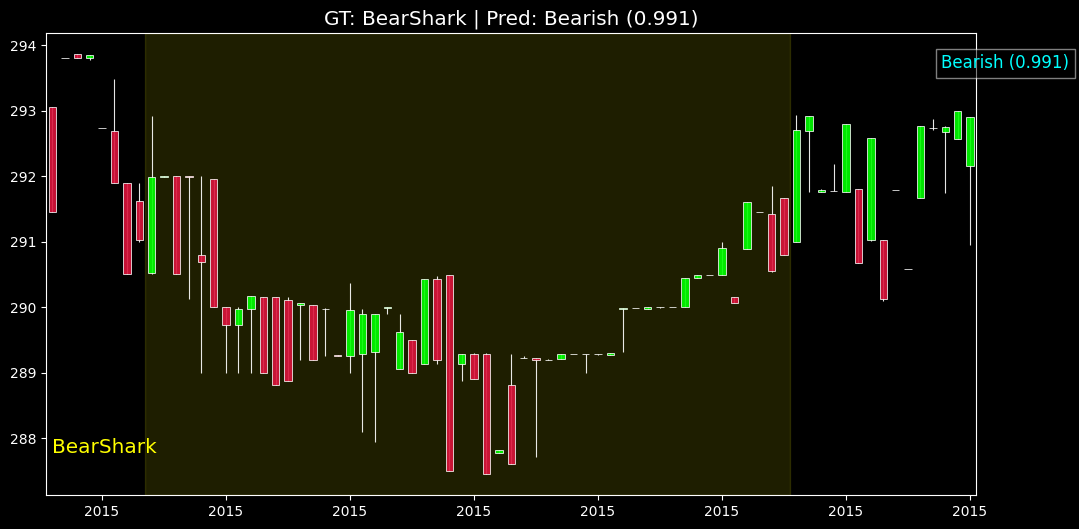

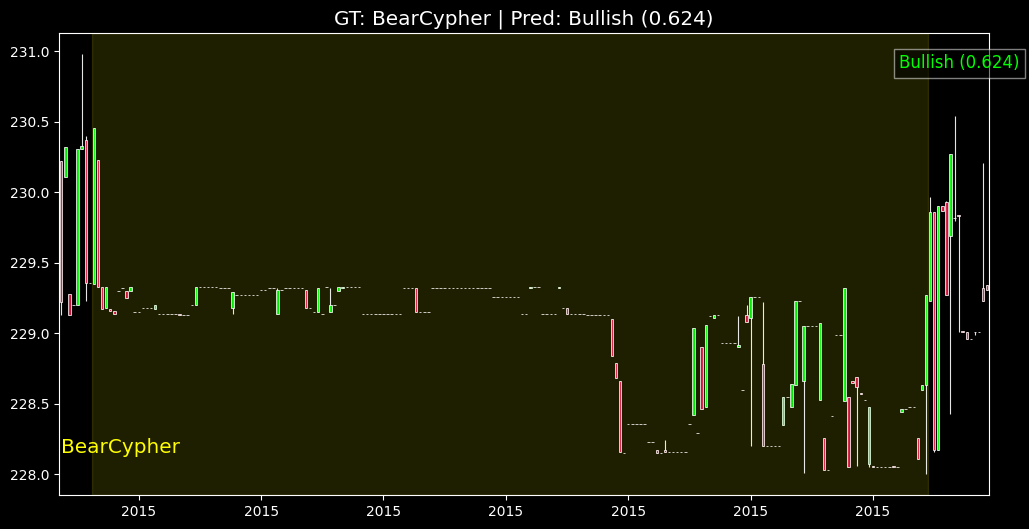

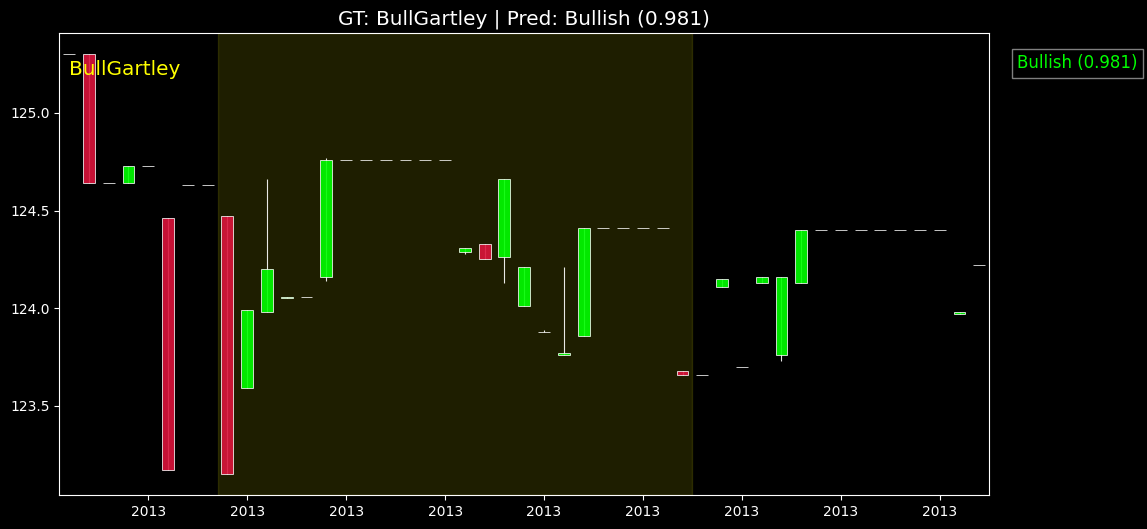

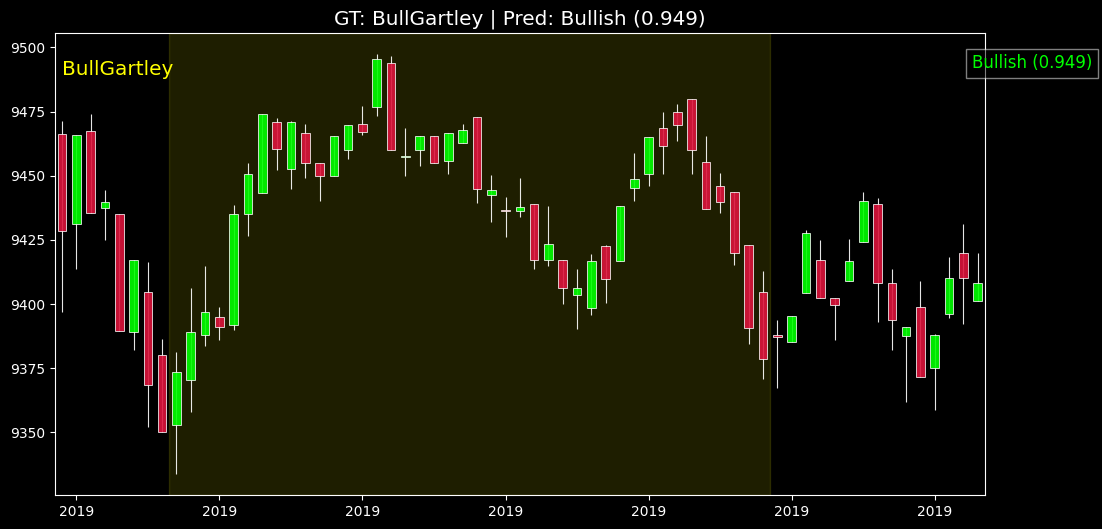

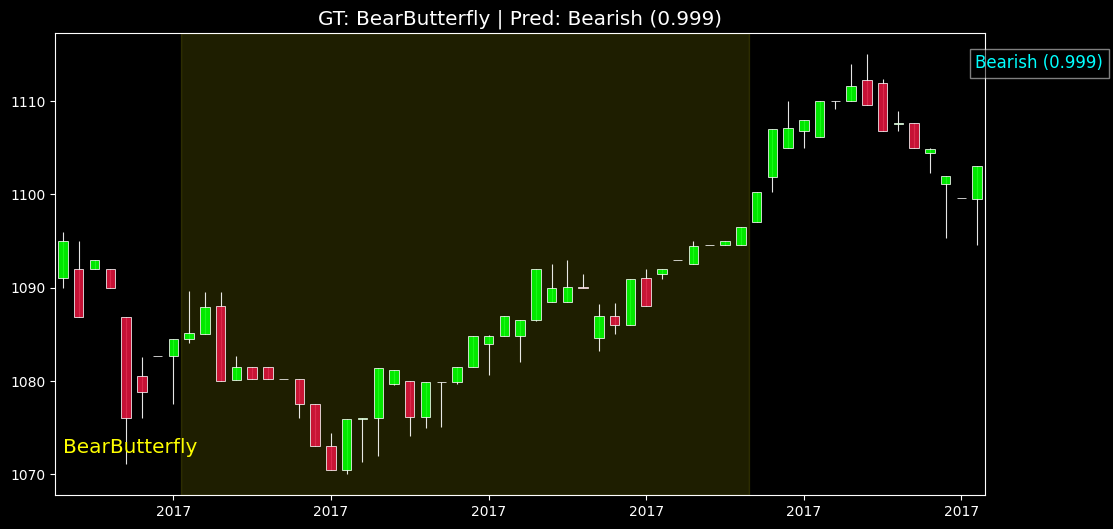

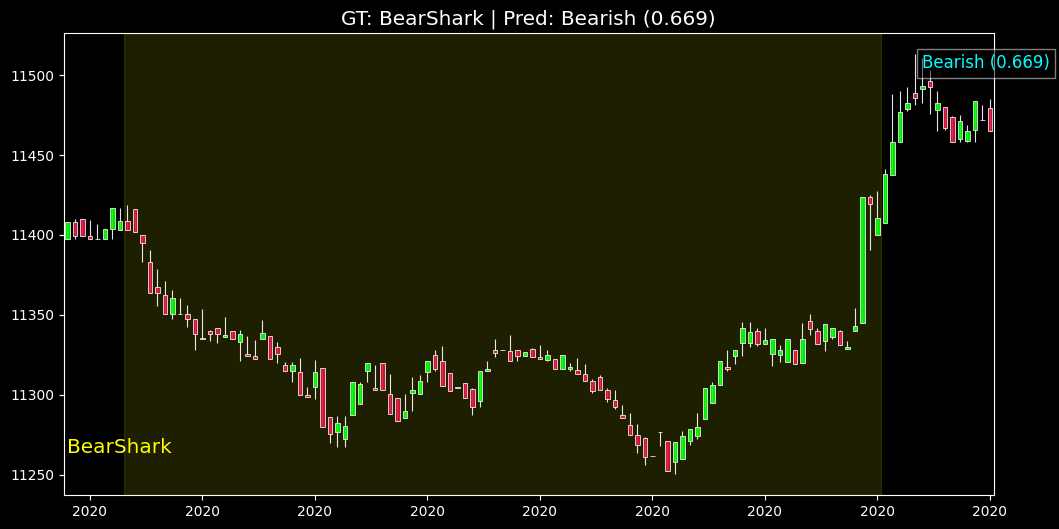

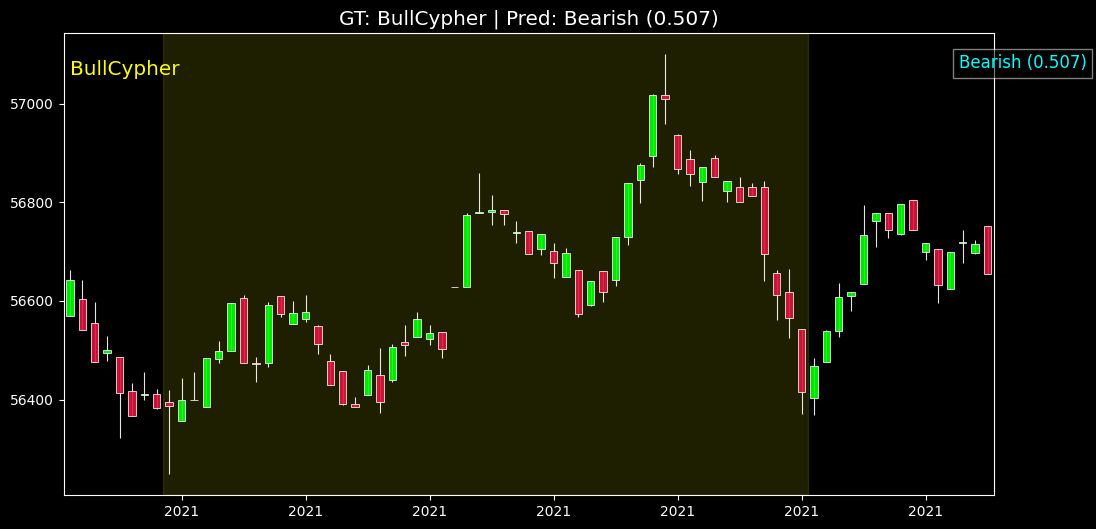

Plotted 10 example groups from eval files
DEBUG: path= patterns\1hour_sigma0.01.csv
DEBUG: indices X,A,B,C,D = 243 253 258 263 274
DEBUG: slice start,end = 235 282 len slice= 48
DEBUG: data.head():
                    date  open  high   low  close
235 2012-01-11 05:00:00  7.14  7.14  7.14   7.14
236 2012-01-11 06:00:00  7.14  7.14  7.14   7.14
237 2012-01-11 07:00:00  7.14  7.14  7.14   7.14
238 2012-01-11 08:00:00  7.14  7.14  7.14   7.14
239 2012-01-11 09:00:00  7.14  7.14  7.14   7.14
DEBUG: data.describe():
             open      high        low      close
count  48.000000  48.00000  48.000000  48.000000
mean    6.974583   7.02375   6.911250   6.961458
std     0.254566   0.23926   0.262999   0.261989
min     6.250000   6.51000   6.250000   6.250000
25%     6.937500   6.95000   6.875000   6.900000
50%     7.000000   7.00000   6.975000   7.000000
75%     7.140000   7.14000   7.140000   7.140000
max     7.380000   7.38000   7.300000   7.380000
DEBUG: full df len = 121604
DEBUG highlig

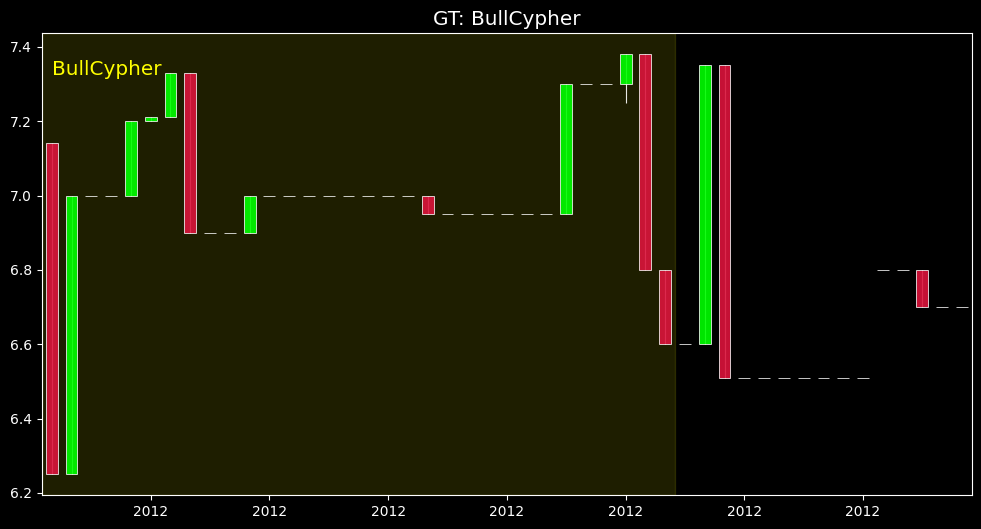

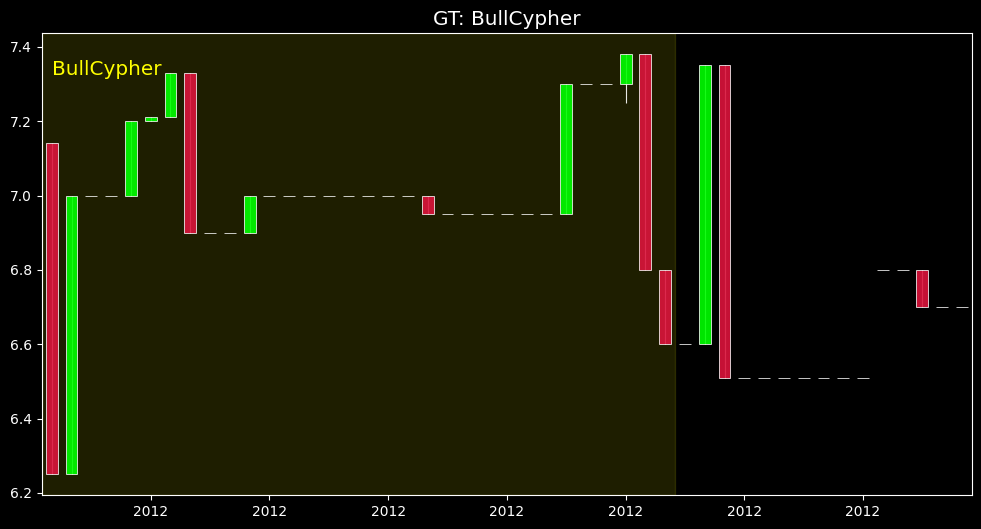

In [ ]:
# Demo: plot some example pattern groups from the eval files using utils.plot_pattern
import importlib
import utils
importlib.reload(utils)
from utils import plot_pattern
import matplotlib.pyplot as plt
import numpy as np

# Show randomized examples from the evaluation files
demo_count = 0
MAX_DEMOS = 10
RANDOM_SEED = 42  # set to None for non-deterministic sampling

candidates = []  # will store tuples (path, X, D, pat_str)
for path in EVAL_FILES:
    df = load_and_clean_csv(path)
    if df is None or len(df) == 0:
        continue
    df = df.reset_index(drop=True)
    df['group_id'] = (df['pattern'] != df['pattern'].shift(1)).cumsum()
    for gid, g in df.groupby('group_id'):
        pat_str = g['pattern'].iloc[0] if len(g) > 0 else ''
        if not (pat_str.startswith('Bull') or pat_str.startswith('Bear')):
            continue
        X = int(g.index[0])
        D = int(g.index[-1])
        if D - X < 4:
            continue
        candidates.append((path, X, D, pat_str))

n_cand = len(candidates)
print(f"Found {n_cand} candidate groups across eval files")
if n_cand == 0:
    print("No candidate groups to plot")
else:
    rng = np.random.RandomState(RANDOM_SEED) if RANDOM_SEED is not None else np.random
    sel_count = min(MAX_DEMOS, n_cand)
    sel_indices = rng.choice(n_cand, size=sel_count, replace=False)

    for idx in sel_indices:
        path, X, D, pat_str = candidates[idx]
        df = load_and_clean_csv(path)
        df = df.reset_index(drop=True)
        # slice the original df using the start/end indices
        g = df.iloc[X : D + 1]
        if g is None or len(g) == 0:
            continue

        A = X + max(1, (D - X)//3)
        B = X + max(1, (D - X)//2)
        C = X + max(1, 2*(D - X)//3)
        bull = pat_str.startswith('Bull')

        # Build sequence exactly as df_to_sequences does (pad/truncate to SEQ_LEN)
        feat = g[FEATURE_COLS].values.astype(np.float32)
        if len(feat) >= SEQ_LEN:
            seq = feat[-SEQ_LEN:]
        else:
            pad_len = SEQ_LEN - len(feat)
            pad = np.zeros((pad_len, feat.shape[1]), dtype=np.float32)
            seq = np.concatenate([pad, feat], axis=0)
        X_seq = np.expand_dims(seq, 0)  # shape (1, SEQ_LEN, n_feat)

        # Try to scale + predict; if model/scaler aren't available, continue gracefully
        pred_label = None
        pred_prob = None
        try:
            Xs = scale_X(X_seq)
            probs = cnn_lstm.predict(Xs, verbose=0)
            pred_idx = int(np.argmax(probs, axis=1)[0])
            pred_label = CLASSES[pred_idx]
            pred_prob = float(probs[0, pred_idx])
        except Exception:
            pred_label = None
            pred_prob = None

        pat = {'X': X, 'A': A, 'B': B, 'C': C, 'D': D, 'name': pat_str, 'bull': bull, 'error': 0.0, 'pred': pred_label, 'pred_prob': pred_prob}
        try:
            # Hide lines and ratios, show 15 bars after D, highlight only the prediction interval (X->D),
            # but keep the following bars visible so you can evaluate whether the prediction succeeded
            fig, ax = plot_pattern(df, pat, pad=8, show=True, show_lines=False, show_ratios=False, post_bars=15, highlight_interval=True)
        except Exception as e:
            print('Error plotting pattern from', path, 'group', (X, D), ':', e)
        demo_count += 1

print('Plotted', demo_count, 'example groups from eval files')

# Debug: inspect first plotted group to verify data slice and plotting coordinates
path = EVAL_FILES[0]
df = load_and_clean_csv(path)
df = df.reset_index(drop=True)
df['group_id'] = (df['pattern'] != df['pattern'].shift(1)).cumsum()
for gid, g in df.groupby('group_id'):
    pat_str = g['pattern'].iloc[0] if len(g) > 0 else ''
    if not (pat_str.startswith('Bull') or pat_str.startswith('Bear')):
        continue
    X = int(g.index[0])
    D = int(g.index[-1])
    if D - X < 4:
        continue
    A = X + max(1, (D - X)//3)
    B = X + max(1, (D - X)//2)
    C = X + max(1, 2*(D - X)//3)
    pat = {'X': X, 'A': A, 'B': B, 'C': C, 'D': D, 'name': pat_str, 'bull': pat_str.startswith('Bull'), 'error':0.0}
    print('DEBUG: path=', path)
    print('DEBUG: indices X,A,B,C,D =', X,A,B,C,D)
    start = max(0,X-8)
    end = min(len(df)-1, D+8)
    data = df.iloc[start:end+1]
    print('DEBUG: slice start,end =', start, end, 'len slice=', len(data))
    print('DEBUG: data.head():\n', data[['date','open','high','low','close']].head())
    print('DEBUG: data.describe():\n', data[['open','high','low','close']].describe())
    # Call plot_pattern with the FULL df so it can include the requested post_bars
    print('DEBUG: full df len =', len(df))
    fig, ax = plot_pattern(df, pat, pad=0, show=False, show_lines=False, show_ratios=False, post_bars=15, highlight_interval=True, debug=True)
    print('DEBUG: plotted to fig, ax; xlim=', ax.get_xlim(), 'ylim=', ax.get_ylim())
    display(fig)
    break

Searching for all false positives...
DEBUG: cnn_lstm in globals() = True, scaler in globals() = True
DEBUG: file=1hour_sigma0.01.csv groups=5352 rows=121604
DEBUG: file=1day_sigma0.02.csv groups=2426 rows=121604
Found 249 total false positives across all eval files
FP: 1hour_sigma0.01.csv X=116485 D=116505 GT=Bearish Pred=Bullish P=0.969 pat_str="BearGartley"


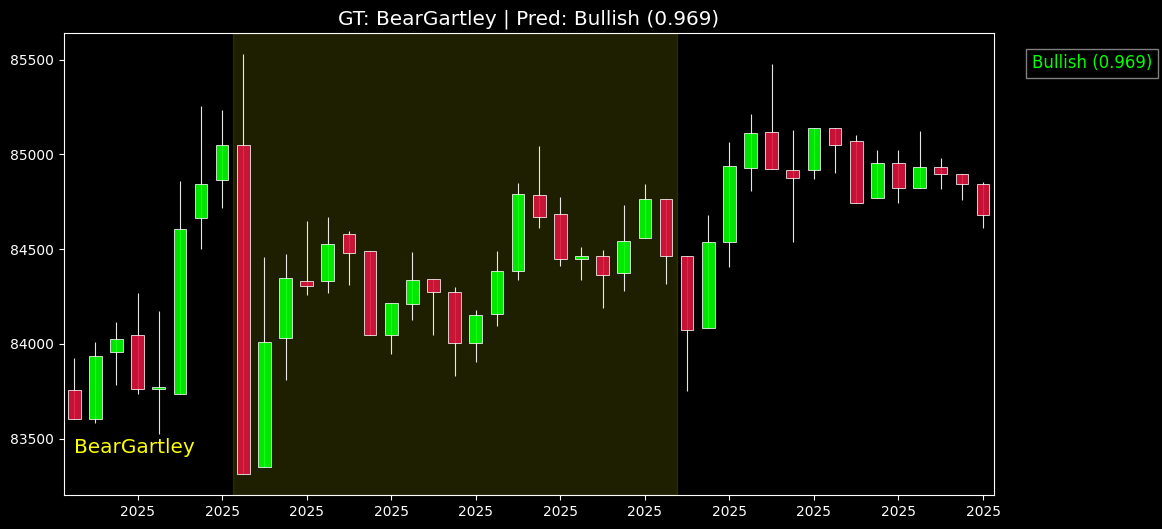

FP: 1hour_sigma0.01.csv X=6655 D=6673 GT=Bullish Pred=Bearish P=0.655 pat_str="BullButterfly"


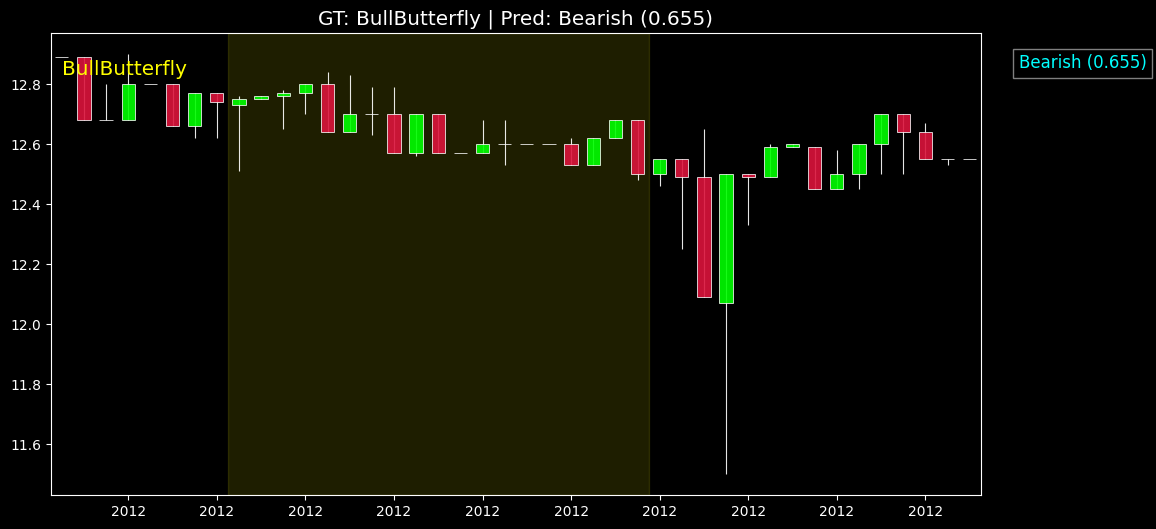

FP: 1hour_sigma0.01.csv X=84820 D=84839 GT=Bearish Pred=Bullish P=0.965 pat_str="BearShark"


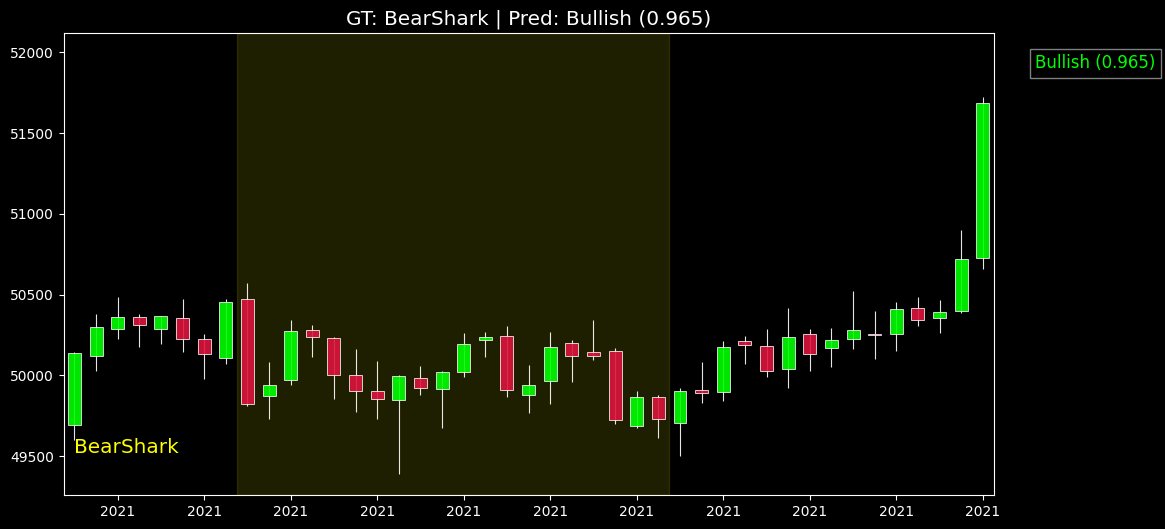

FP: 1hour_sigma0.01.csv X=52019 D=52027 GT=Bearish Pred=Bullish P=0.652 pat_str="BearButterfly"


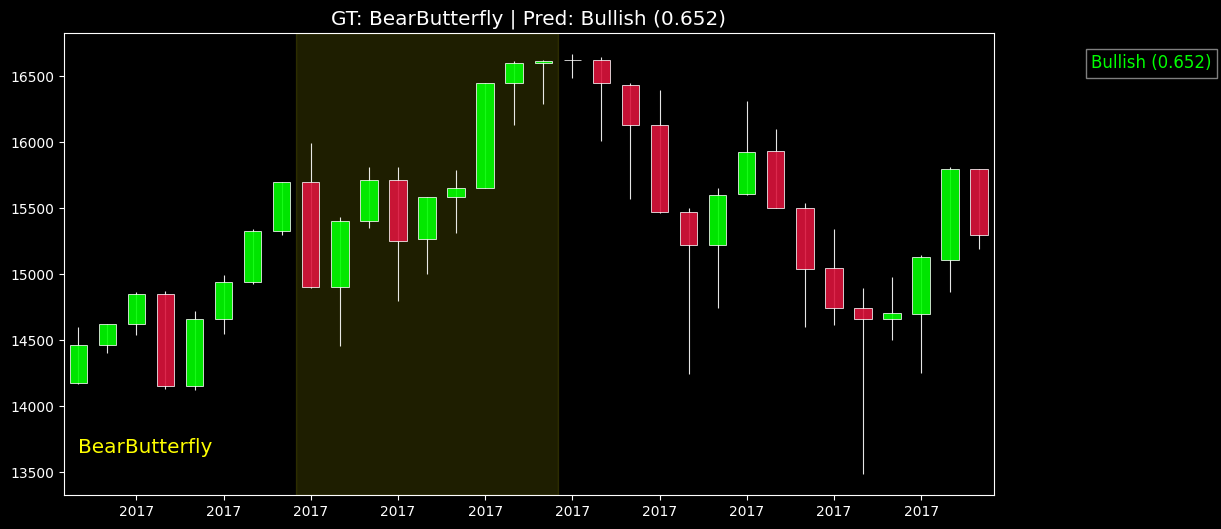

FP: 1hour_sigma0.01.csv X=92097 D=92101 GT=Bearish Pred=Bullish P=0.523 pat_str="BearButterfly"


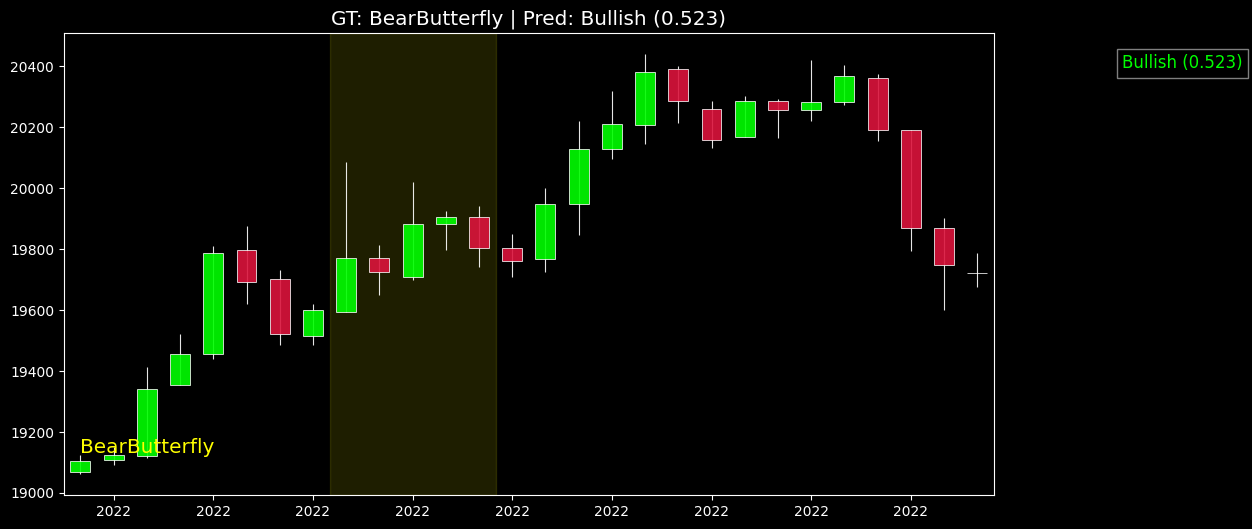

FP: 1day_sigma0.02.csv X=35761 D=35872 GT=Bearish Pred=Bullish P=0.846 pat_str="BearButterfly"


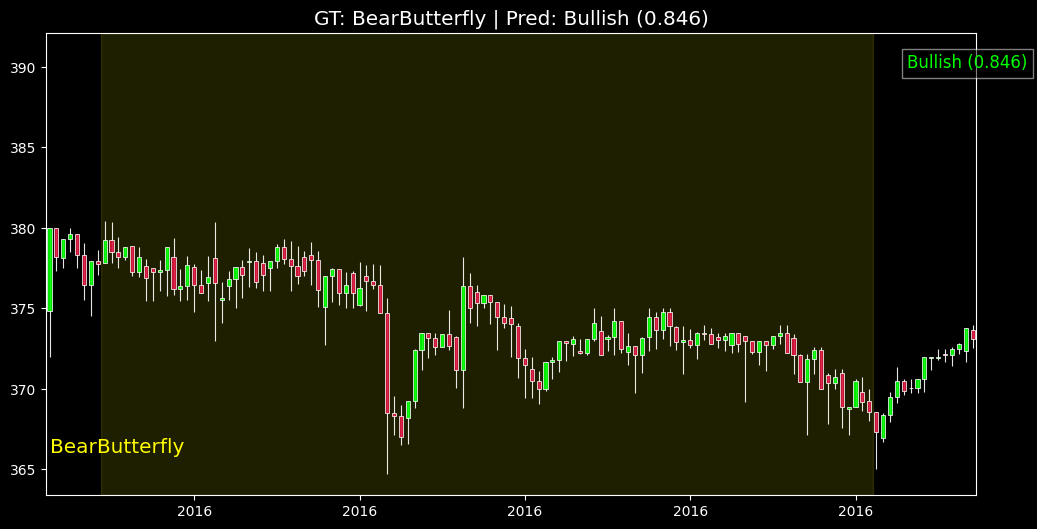

FP: 1day_sigma0.02.csv X=57374 D=57417 GT=Bullish Pred=Bearish P=0.630 pat_str="BullShark"


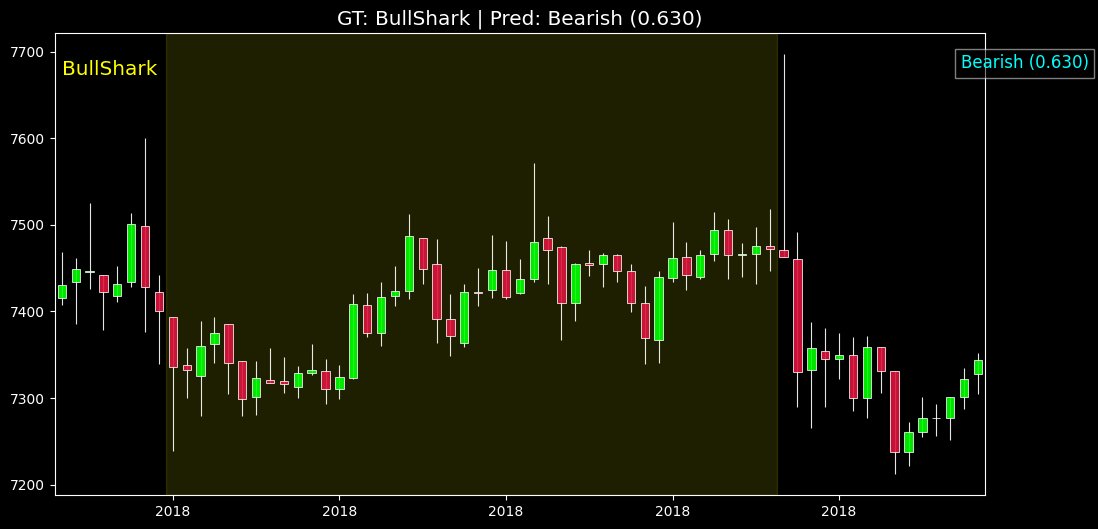

FP: 1day_sigma0.02.csv X=39634 D=39667 GT=Bearish Pred=Bullish P=0.599 pat_str="BearGartley"


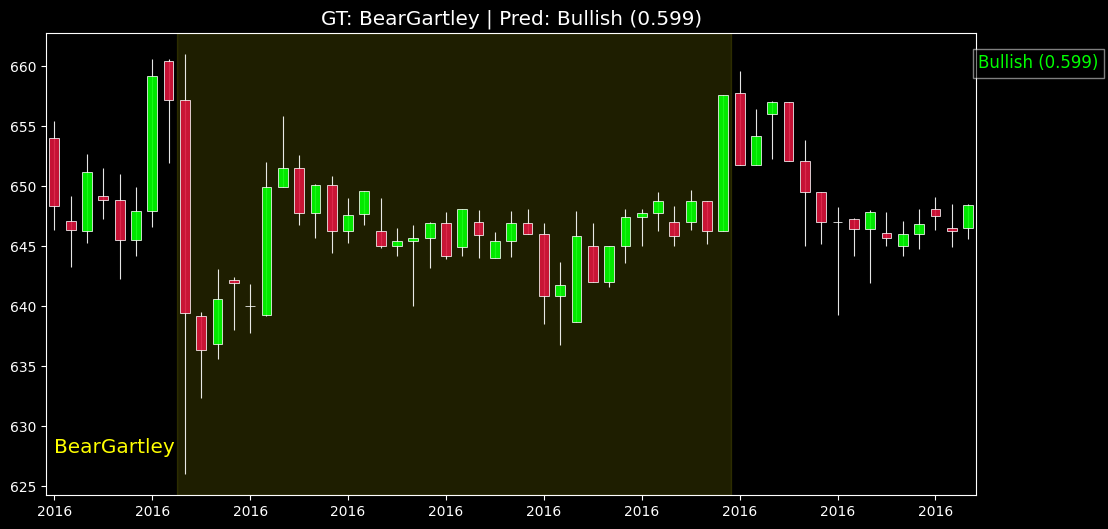

Finished FP scan. Displayed 8 random false positives out of 249 total; examined 4619 candidates; skipped_preds=0


In [ ]:
# Find and visualize false positives in the evaluation files (improved and debugged)
# Scans EVAL_FILES, collects all false positives, then displays random samples
MAX_FP = 8
RANDOM_SEED_FP = 42  # set to None for non-deterministic sampling
examined = 0
skipped_pred = 0

EVAL_FILES = [
    # "1hour_sigma0.01.csv",
    # "1minute_sigma0.005.csv",
    "1day_sigma0.02.csv"
]
EVAL_FILES = [os.path.join(DATA_DIR, f) for f in EVAL_FILES]
eval_set = set(EVAL_FILES)
# First pass: collect all false positives
false_positives = []  # will store tuples (path, X, D, pat_str, pat_s, A, B, C, true_label)
print(f"Searching for all false positives...")
print(f"DEBUG: cnn_lstm in globals() = {'cnn_lstm' in globals()}, scaler in globals() = {'scaler' in globals()}")

for path in EVAL_FILES:
    df = load_and_clean_csv(path)
    if df is None or len(df) == 0:
        print(f"DEBUG: skipping empty file {path}")
        continue
    df = df.reset_index(drop=True)
    df['group_id'] = (df['pattern'] != df['pattern'].shift(1)).cumsum()
    groups = list(df.groupby('group_id'))
    print(f"DEBUG: file={os.path.basename(path)} groups={len(groups)} rows={len(df)}")
    
    for gid, g in groups:
        pat_str = str(g['pattern'].iloc[0]) if len(g) > 0 else ''
        pat_s = pat_str.strip().lower()
        # Accept any label containing 'bull' or 'bear' (case-insensitive)
        if not (('bull' in pat_s) or ('bear' in pat_s)):
            continue
        X = int(g.index[0]); D = int(g.index[-1])
        if D - X < 4:
            continue
        A = X + max(1, (D - X)//3)
        B = X + max(1, (D - X)//2)
        C = X + max(1, 2*(D - X)//3)

        # Build the sequence the same way df_to_sequences does
        feat = g[FEATURE_COLS].values.astype(np.float32)
        if len(feat) >= SEQ_LEN:
            seq = feat[-SEQ_LEN:]
        else:
            pad_len = SEQ_LEN - len(feat)
            pad = np.zeros((pad_len, feat.shape[1]), dtype=np.float32)
            seq = np.concatenate([pad, feat], axis=0)
        X_seq = np.expand_dims(seq, 0)

        # Predict using the current model/scaler
        try:
            if 'scaler' not in globals() or 'cnn_lstm' not in globals():
                raise RuntimeError('Missing scaler or model in the notebook session. Run training/initialization cells first.')
            Xs = scale_X(X_seq)
            probs = cnn_lstm.predict(Xs, verbose=0)
            pred_idx = int(np.argmax(probs, axis=1)[0])
            pred_label = CLASSES[pred_idx]
            pred_prob = float(probs[0, pred_idx])
        except Exception as e:
            skipped_pred += 1
            print(f"Skipping prediction for file={os.path.basename(path)} gid={gid} due to error: {e}")
            continue

        examined += 1
        true_label = 'Bullish' if 'bull' in pat_s else 'Bearish'
        if pred_label != true_label:
            false_positives.append((path, X, D, pat_str, pat_s, A, B, C, true_label, pred_label, pred_prob))

n_fps = len(false_positives)
print(f"Found {n_fps} total false positives across all eval files")

# Second pass: randomly sample and display
if n_fps == 0:
    print("No false positives to display")
else:
    rng = np.random.RandomState(RANDOM_SEED_FP) if RANDOM_SEED_FP is not None else np.random
    sel_count = min(MAX_FP, n_fps)
    sel_indices = rng.choice(n_fps, size=sel_count, replace=False)
    
    fp_count = 0
    for idx in sel_indices:
        path, X, D, pat_str, pat_s, A, B, C, true_label, pred_label, pred_prob = false_positives[idx]
        print(f'FP: {os.path.basename(path)} X={X} D={D} GT={true_label} Pred={pred_label} P={pred_prob:.3f} pat_str="{pat_str}"')
        
        df = load_and_clean_csv(path)
        df = df.reset_index(drop=True)
        pat = {'X': X, 'A': A, 'B': B, 'C': C, 'D': D, 'name': pat_str, 'bull': pat_str.lower().startswith('bull'), 'error': 0.0, 'pred': pred_label, 'pred_prob': pred_prob}
        try:
            fig, ax = plot_pattern(df, pat, pad=8, show=True, show_lines=False, show_ratios=False, post_bars=15, highlight_interval=True)
        except Exception as e:
            print('Error plotting FP', e)
        fp_count += 1

print(f'Finished FP scan. Displayed {fp_count} random false positives out of {n_fps} total; examined {examined} candidates; skipped_preds={skipped_pred}')